In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai2.vision.all import (create_body, create_head, create_cnn_model, 
                                AdaptiveConcatPool2d)
from fastai2.vision import models
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from htools import *

In [3]:
class ConvBlock(nn.Module):
    
    def __init__(self, c_in, c_out, kernel=3, **kwargs):
        super().__init__()
        self.layers = nn.Sequential(nn.Conv2d(c_in, c_out, kernel, **kwargs),
                                    nn.BatchNorm2d(c_out),
                                    nn.LeakyReLU())
        
    def forward(self, x):
        return self.layers(x)

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class ConvNet(nn.Module):
    
    def __init__(self, c_dims, kernel=3, **kwargs):
        super().__init__()
        self.layers = nn.Sequential(*flatten(
            [ConvBlock(c_in, c_out).layers 
             for c_in, c_out in zip(dims, dims[1:])]
        ))
        
    def forward(self, x):
        return self.layers(x)

In [5]:
x = torch.randn(2, 3, 128, 128)

In [6]:
dims = [3, 16, 32, 64]
net = ConvNet(dims)
net

ConvNet(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
  )
)

In [7]:
net(x).shape

torch.Size([2, 64, 122, 122])

In [8]:
mp = nn.AdaptiveMaxPool2d(1)
mp(x).shape

torch.Size([2, 3, 1, 1])

In [9]:
ap = nn.AdaptiveAvgPool2d(1)
ap(x).shape

torch.Size([2, 3, 1, 1])

In [10]:
cat = torch.cat([mp(x), ap(x)], dim=1).squeeze()
print(cat.shape)
cat

torch.Size([2, 6])


tensor([[ 4.7079e+00,  4.5846e+00,  4.0502e+00, -1.7296e-03, -7.4472e-03,
         -8.7114e-03],
        [ 4.1338e+00,  4.1062e+00,  4.2803e+00, -6.5789e-03,  1.0375e-02,
         -6.1685e-05]])

In [11]:
w = F.softmax(cat, dim=1)
print(w.shape)
w

torch.Size([2, 6])


tensor([[0.4117, 0.3639, 0.2133, 0.0037, 0.0037, 0.0037],
        [0.3146, 0.3060, 0.3642, 0.0050, 0.0051, 0.0050]])

In [12]:
w*cat

tensor([[ 1.9383e+00,  1.6685e+00,  8.6380e-01, -6.4142e-06, -2.7461e-05,
         -3.2082e-05],
        [ 1.3004e+00,  1.2567e+00,  1.5590e+00, -3.2943e-05,  5.2841e-05,
         -3.1090e-07]])

In [13]:
x2 = net(x)
x2.shape

torch.Size([2, 64, 122, 122])

In [58]:
class AttentiveConcatPool2d(nn.Module):
    
    def __init__(self, c_in, soften=True):
        super().__init__()
        self.adapt = AdaptiveConcatPool2d(1)
#         self.temp = temp
        self.c_in = c_in
        self.soften = soften
        self.scalar = self._compute_scalar()
        
    def forward(self, x, return_attention=False):
        res = self.adapt(x).squeeze(-1).squeeze(-1)
        weights = res.div(self.scalar).softmax(dim=1)
        res = res * weights
        return (res, weights) if return_attention else res
    
    def _compute_scalar(self):
        # Larger denominator smoothes out softmax. The 2 inside the sqrt
        # accounts for the fact that the concat pooling doubles the channel
        # dimension (using bert's method of sqrt(n_features) as a reference).
        # The one outside the sqrt is just an idea, w/ images we often have a
        # number of channels by the time we're ready for the final concat
        # pool, whereas bert was operating on vectors of fixed length 64.
        # Worried we'd smooth the softmax too much and just get a uniform 
        # dist.
        return np.sqrt(self.c_in*2) / 2 if self.soften else 1

In [59]:
attn = AttentiveConcatPool2d(c_in=64)
attn

AttentiveConcatPool2d(
  (adapt): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
)

In [60]:
attn.scalar

5.656854249492381

In [62]:
y, a = attn(x2, return_attention=True)
y.shape, a.shape

(torch.Size([2, 128]), torch.Size([2, 128]))

In [63]:
y

tensor([[0.0427, 0.0377, 0.0360, 0.0378, 0.0344, 0.0323, 0.0376, 0.0455, 0.0334,
         0.0343, 0.0448, 0.0391, 0.0400, 0.0478, 0.0361, 0.0459, 0.0678, 0.0429,
         0.0380, 0.0426, 0.0379, 0.0422, 0.0565, 0.0345, 0.0352, 0.0413, 0.0432,
         0.0430, 0.0494, 0.0422, 0.0368, 0.0560, 0.0457, 0.0511, 0.0413, 0.0552,
         0.0416, 0.0324, 0.0498, 0.0335, 0.0379, 0.0465, 0.0410, 0.0408, 0.0568,
         0.0513, 0.0314, 0.0426, 0.0412, 0.0397, 0.0357, 0.0526, 0.0345, 0.0473,
         0.0368, 0.0390, 0.0423, 0.0424, 0.0447, 0.0419, 0.0444, 0.0523, 0.0521,
         0.0581, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
         0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
         0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
         0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
         0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
         0.0021, 0.0021, 0.0

In [64]:
a

tensor([[0.0103, 0.0098, 0.0096, 0.0098, 0.0094, 0.0092, 0.0098, 0.0106, 0.0093,
         0.0094, 0.0105, 0.0099, 0.0100, 0.0108, 0.0096, 0.0106, 0.0127, 0.0103,
         0.0098, 0.0103, 0.0098, 0.0103, 0.0117, 0.0095, 0.0095, 0.0102, 0.0104,
         0.0103, 0.0110, 0.0103, 0.0097, 0.0116, 0.0106, 0.0111, 0.0102, 0.0115,
         0.0102, 0.0092, 0.0110, 0.0093, 0.0098, 0.0107, 0.0101, 0.0101, 0.0117,
         0.0112, 0.0091, 0.0103, 0.0102, 0.0100, 0.0096, 0.0113, 0.0095, 0.0108,
         0.0097, 0.0099, 0.0103, 0.0103, 0.0105, 0.0102, 0.0105, 0.0113, 0.0113,
         0.0118, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053,
         0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053,
         0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053,
         0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053,
         0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053, 0.0053,
         0.0053, 0.0053, 0.0

## TODO

- find error w/ new head() func
- experiment w/ conv1d -> split (see how this creates Q, K, V)
    - try incorporating this into concat pool, either for Mike's text version or this img version
- looks like gpt2 uses dropout on attn weights. Look into this and consider if it would be useful here.

In [288]:
# 99% FASTAI2 CODE
from fastai2.vision.all import Flatten, SigmoidRange, LinBnDrop, L


def new_create_head(nf, n_out, lin_ftrs=None, ps=0.5, bn_final=False, lin_first=False, y_range=None):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `n_out` classes."
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = [AttentiveConcatPool2d(lin_ftrs[1]), Flatten()]
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    if y_range is not None: layers.append(SigmoidRange(*y_range))
    return nn.Sequential(*layers)

In [289]:
head = new_create_head(nf=64, n_out=3)
head

Sequential(
  (0): AttentiveConcatPool2d(
    (adapt): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=64, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=3, bias=False)
)

In [292]:
head[:3](x2)

RuntimeError: running_mean should contain 128 elements not 64

In [31]:
z = torch.randn(64)
z

tensor([ 0.3749,  0.6521,  0.2097, -0.1590, -0.6011, -0.8098, -0.8483,  0.4938,
        -0.6983,  0.1183,  0.2271,  0.2014,  0.8984,  2.3043,  0.8743,  0.0295,
         0.4691, -1.2409,  0.4216, -0.9734,  1.3953,  0.3592,  0.4468, -0.9488,
         1.2025, -0.8832, -0.8199,  1.6443, -0.6326, -0.8411,  1.7204, -0.0496,
         0.2285,  0.3712, -0.4643,  0.3280, -1.0556,  1.8892, -1.1080,  1.2983,
         0.0726, -1.0660, -3.1903,  0.4978, -0.1535, -2.1904,  0.8132, -0.6962,
        -1.1645,  0.1726, -0.1345, -0.0894,  1.0166, -0.4312,  0.5702, -0.7984,
         1.5788, -0.1671, -0.7340,  1.0457,  0.8051, -0.9912, -1.6740,  0.2522])

In [32]:
z.sort()[0]

tensor([-3.1903, -2.1904, -1.6740, -1.2409, -1.1645, -1.1080, -1.0660, -1.0556,
        -0.9912, -0.9734, -0.9488, -0.8832, -0.8483, -0.8411, -0.8199, -0.8098,
        -0.7984, -0.7340, -0.6983, -0.6962, -0.6326, -0.6011, -0.4643, -0.4312,
        -0.1671, -0.1590, -0.1535, -0.1345, -0.0894, -0.0496,  0.0295,  0.0726,
         0.1183,  0.1726,  0.2014,  0.2097,  0.2271,  0.2285,  0.2522,  0.3280,
         0.3592,  0.3712,  0.3749,  0.4216,  0.4468,  0.4691,  0.4938,  0.4978,
         0.5702,  0.6521,  0.8051,  0.8132,  0.8743,  0.8984,  1.0166,  1.0457,
         1.2025,  1.2983,  1.3953,  1.5788,  1.6443,  1.7204,  1.8892,  2.3043])

In [33]:
def plot_bar(data, act_fn=identity, title=None, **kwargs):
    data = act_fn(data).sort()[0]
    fig, ax = plt.subplots(**kwargs)
    plt.bar(range(data.shape[0]), data)
    if title: plt.title(title)
    plt.show()

In [34]:
def plot_scatter(data, act_fn=identity, title=None, **kwargs):
    fig, ax = plt.subplots(**kwargs)
    plt.scatter(data, act_fn(data), s=1)
    plt.xlabel('Original')
    plt.ylabel('Transformed')
    if title: plt.title(title)
    plt.show()

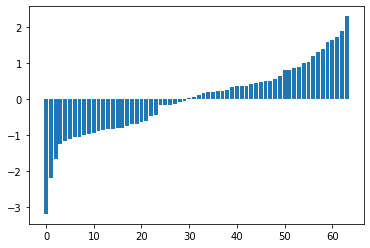

In [35]:
plot_bar(z)

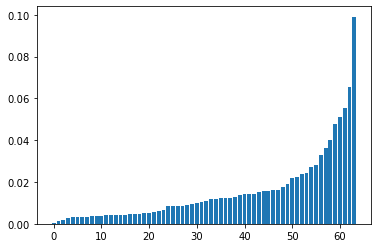

In [36]:
plot_bar(z, nn.Softmax(dim=-1))

In [327]:
class SmoothSoftmax(nn.Module):
    
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
        
    def forward(self, x):
        return x.div(self.scale).softmax(dim=-1)

In [369]:
z = torch.randn(512)

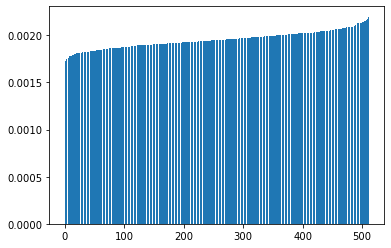

In [374]:
plot_bar(z, SmoothSoftmax(z.shape[-1]**.5))

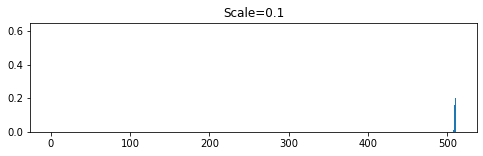

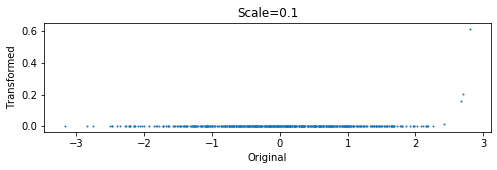

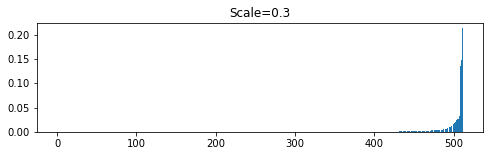

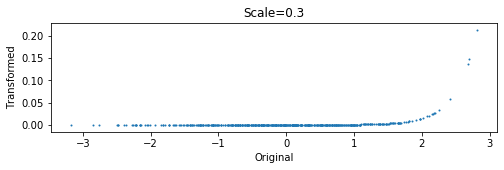

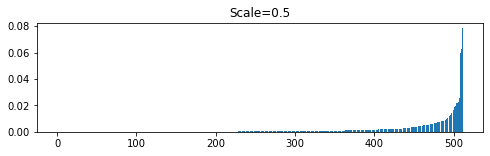

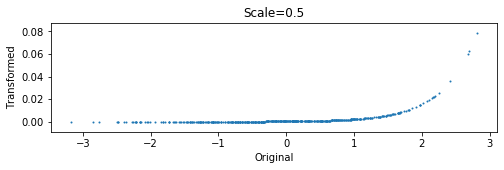

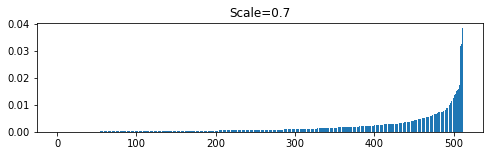

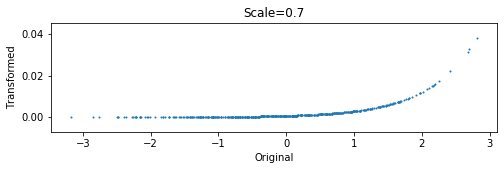

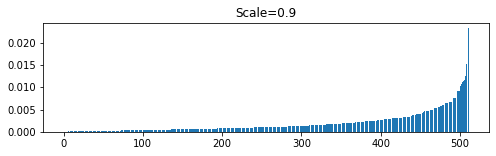

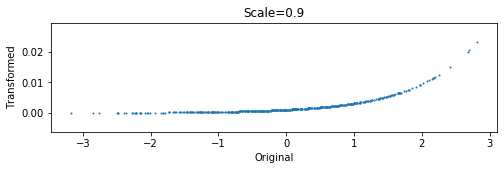

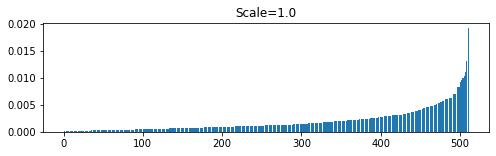

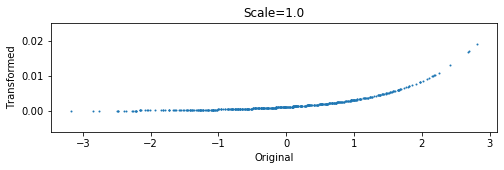

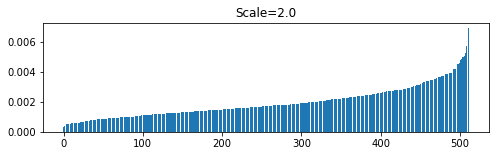

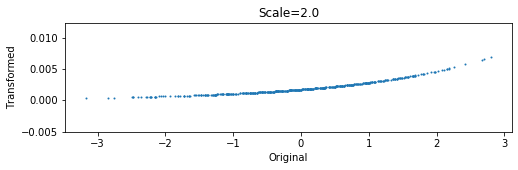

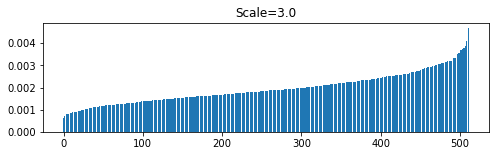

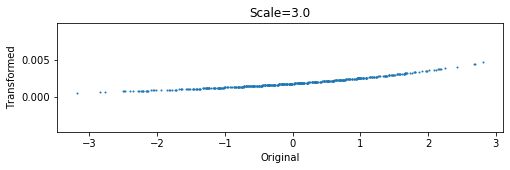

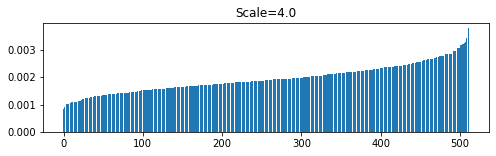

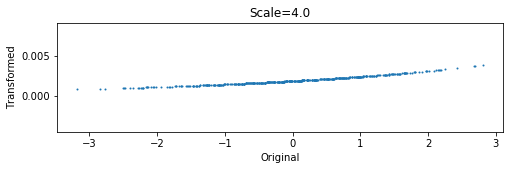

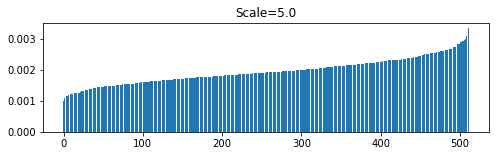

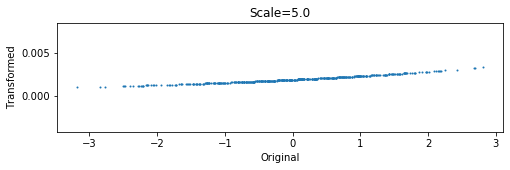

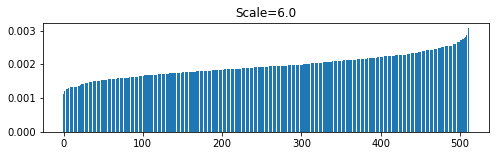

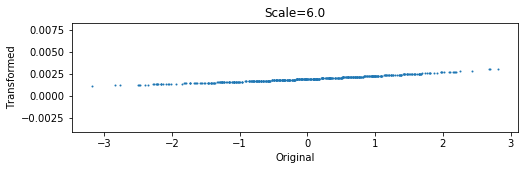

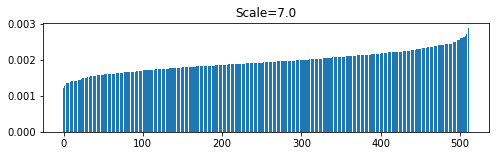

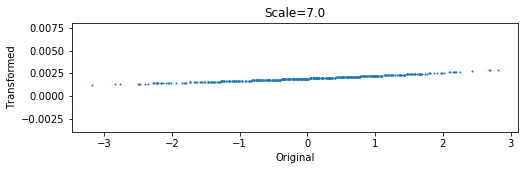

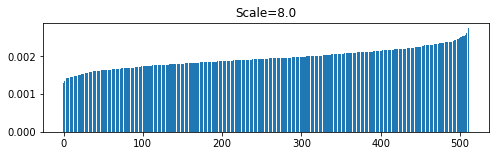

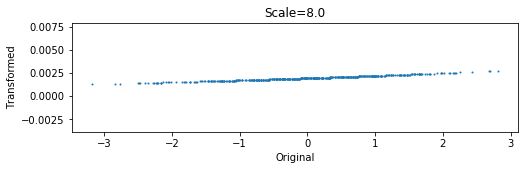

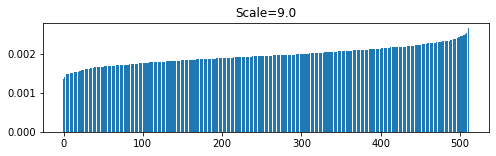

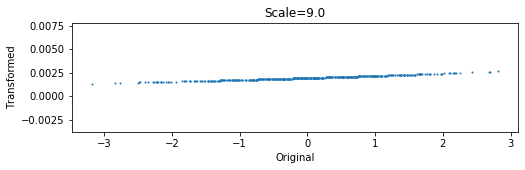

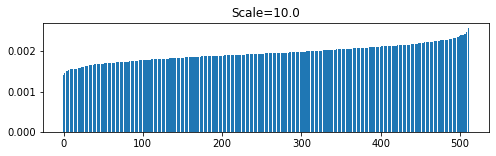

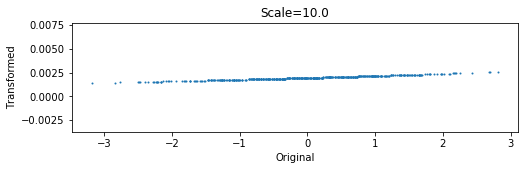

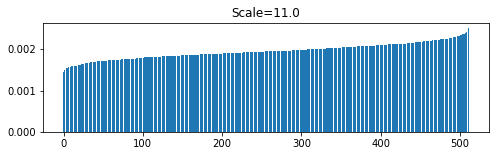

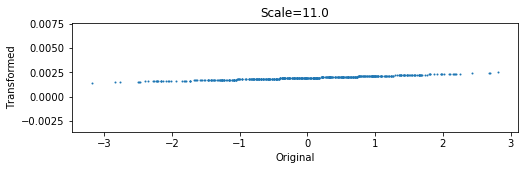

In [354]:
for s in np.r_[.1:1:.2, 1:12]:
    plot_bar(z, SmoothSoftmax(s), f'Scale={s:.1f}', figsize=(8, 2))
    plot_scatter(z, SmoothSoftmax(s), f'Scale={s:.1f}', figsize=(8, 2))

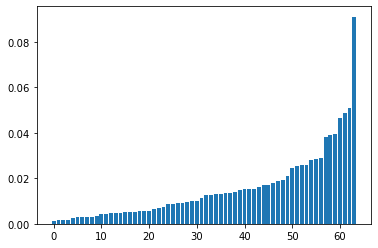

In [363]:
x = torch.randn(64)
plot_bar(x, nn.Softmax(dim=-1))

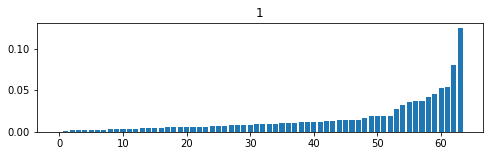

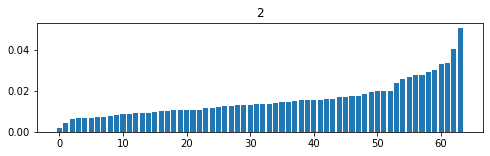

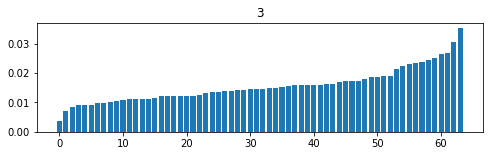

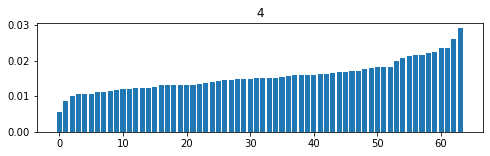

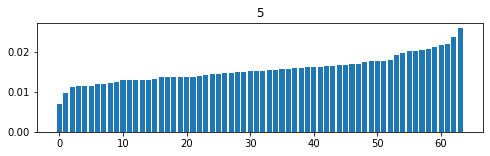

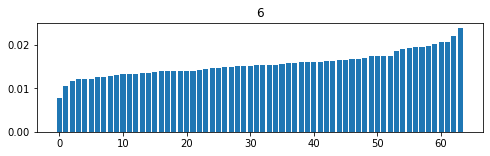

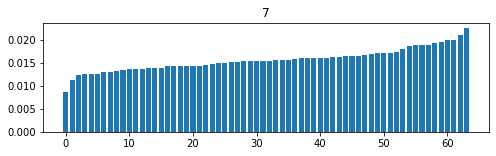

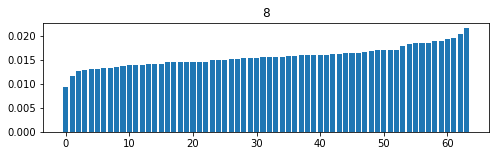

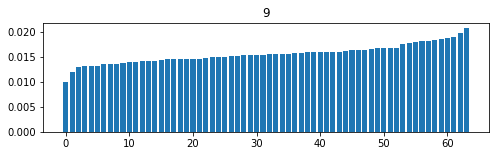

In [362]:
for i in range(1, 10):
    plot_bar(x, SmoothSoftmax(i), title=str(i), figsize=(8, 2))

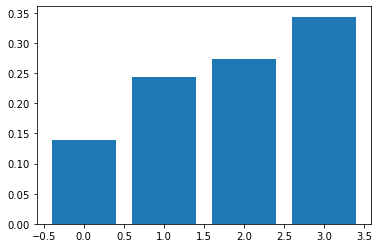

In [367]:
plot_bar(torch.randn(4), SmoothSoftmax(2))

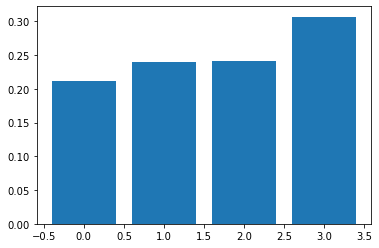

In [368]:
plot_bar(torch.randn(4), SmoothSoftmax(8))